# Intro to Neural Networks: Classifying jets with DNNs

Written by Johannes Wagner

In [ ]:
#import some packages and fetch data
from sklearn.datasets import fetch_openml
import numpy as np
import torch as th
import torch.nn as nn
import pandas
import matplotlib.pyplot as plt

In [ ]:
dataset = fetch_openml('hls4ml_lhc_jets_hlf')

In this notebook, you will learn how to implement a basic neural network to classify particle jets. We will go into further detail about jets next week, but for now you can think of each jet as a collection of particle tracks that have some common origin. Jets can be classified based on their origin, which is what we will concern ourselves with in this exercise. Our dataset consists of around a million jets, each of which has 16 associated high-level features. These are various quantities that are calculated by hand based on the particle tracks contained in each jet. For today, we will mostly ignore the physical meaning of these quantities and just think of them as convenient features for us to use in our classification problem. A full list of the variables is given in table 1 of [this paper](https://iopscience.iop.org/article/10.1088/1748-0221/13/07/P07027).

<div>
<img src="https://i2.wp.com/www.particlebites.com/wp-content/uploads/2016/08/B-tagging_diagram.png" width="300"/>
</div>

# Task 1: Analyze the input data

There are 5 classes of jets in our input data: gluon jets, quark jets, tau jets, W jets and Z jets. These tell us which kind of particle generated each particular jet. Let's start by looking into our dataset a bit more to try and understand what it looks like. The block of code below gets our data into a nicer format:

In [ ]:
#split our dataset into inputs (X) and target labels (y)
X, y_raw = dataset['data'].to_numpy(), dataset['target'].to_numpy()

features = list(dataset['data'].columns)
njets = y_raw.shape[0]
labels = np.unique(y_raw)

print("There are {} total jets in our dataset with labels \"{}\"".format(njets, ', '.join(labels)))
print("Our {} input features are \"{}\"".format(len(features), ', '.join(features)))

There are 830000 total jets in our dataset with labels "g, q, t, w, z"
Our 16 input features are "zlogz, c1_b0_mmdt, c1_b1_mmdt, c1_b2_mmdt, c2_b1_mmdt, c2_b2_mmdt, d2_b1_mmdt, d2_b2_mmdt, d2_a1_b1_mmdt, d2_a1_b2_mmdt, m2_b1_mmdt, m2_b2_mmdt, n2_b1_mmdt, n2_b2_mmdt, mass_mmdt, multiplicity"


Now we can start looking at the distributions of some of our 16 input variables for each group of jets. Remember that the neural network we will set up in a few minutes is going to be using the entirety of this 16-dimensional input space to find a rule that separates the different jet classes from each other as best as possible. As humans, we cannot visualize a 16-dimensional space, so let's try and get a feel for this process by looking at a 1-dimensional subspace of this larger input space (i.e. by picking one of our 16 features and examining its distribution independently from all the others). The code snippet below generates 5 histograms (one for each jet class) of one input feature at a time (which you can pick by setting the *findex* variable). Feel free to play around with this a bit to see which variables give the most separation power between different jet flavors.

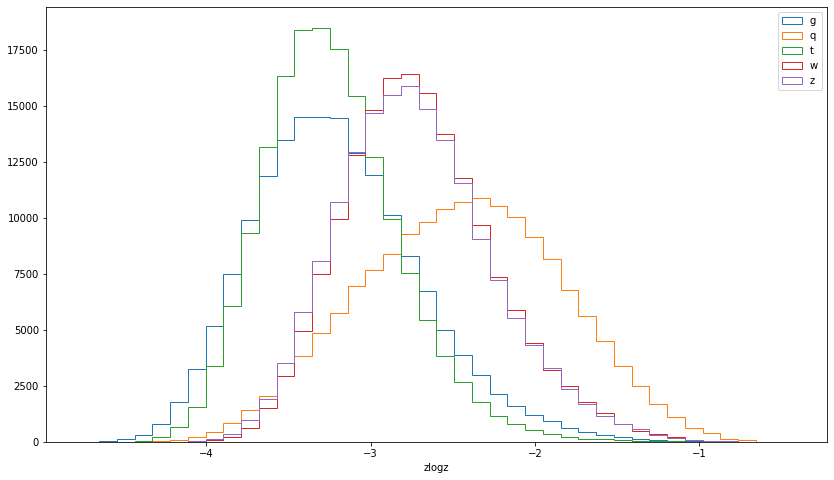

In [ ]:
findex = 0 #can have values from 0-15

fig = plt.figure(figsize=(14,8))
bins = np.histogram(X[:,findex],bins=40)[1]
histograms = (X[:,findex][y_raw=='g'],X[:,findex][y_raw=='q'],X[:,findex][y_raw=='t'],X[:,findex][y_raw=='w'],X[:,findex][y_raw=='z'])
for label in labels:
  plt.hist(X[y_raw==label][:,findex],bins=bins,histtype='step',stacked=True,fill=False,label=label)
xlabel = plt.xlabel(features[findex])
plt.legend()
plt.show()

$\textbf{Question 1}$: By eye, which of the following features do you think is most useful for distinguishing between gluon jets ('g') and top jets ('t'): zlogz, c1_bs_mmdt or c1_b2_mmdt? Note that zlogz has findex=0, c1_b0_mmdt has findex=1 and c1_bs_mmdt has findex=3.

$\textbf{Question 2}$: If you had to find a rule to distinguish "w" and "z" jets from "g", "q" and "t" jets based only on the variable d2_a1_b2_mmdt (findex=9), what would you set this rule as? Note that this would be a rule of the form "classify as w/z if d2_a1_b2_mmdt < X and g/q/t otherwise" where X is a variable.

Now that we have a bit more of an understanding of our data, let's start building our neural network classifier.

# Task 2: Set up your neural network

In order to be able to feed our data into a neural network we will need to "one-hot encode" our data labels. This means that we want to transform each class label into an array, such that e.g. "g" becomes [1,0,0,0,0] and "z" becomes [0,0,0,0,1]. This is so that our neural network will be trained to output class probabilities.

In [ ]:
#transform labels into desired format
y = np.zeros((y_raw.shape[0], labels.shape[0]))
for i in range(y_raw.shape[0]):
  y[i,np.where(labels==y_raw[i])] = 1

Now we will split our inputs into training, validation and testing data (using an 80%, 10%, 10% split). We need to do this in order to avoid falsifing our results by testing our algorithm on the same data we trained it on. The validation data will be used to test our network after each epoch to check for overtraining. If the training loss becomes much lower than the validation loss, this is a telltale sign that we're getting into that regime.

In [ ]:
X_train = X[:int(njets*0.8)]
y_train = y[:int(njets*0.8)]
X_val = X[int(njets*0.8):int(njets*0.9)]
y_val = y[int(njets*0.8):int(njets*0.9)]
X_test = X[int(njets*0.9):]
y_test = y[int(njets*0.9):]

We also need to define our DNN model. This is done very simply in pyTorch by defining a new class that inherits from the pre-existing nn.Module class (so pyTorch knows what kind of object it's dealing with). We really only need to implement two functions: the initialization function that defines our model's attributes and the forward function that runs the forward pass. Let's try defining a network with 3 hidden layers. We will use separate activation functions for the hidden layers (ReLU is always a good choice here) and the output layer (Softmax is most useful for multi-class classification).

$\textbf{Question 3}$: Look at some online resources describing the softmax function. Why do you think it is used in multi-class classification problems? What do our outputs look like in this case?

$\textbf{Coding Question 1}$: Fill in the blanks in the DNN definition below. For the purposes of the test run, we want to apply 4 linear layers to our inputs. Start by defining these layers in the class initialization function (you can use *infeatures*, *outfeatures* and hidden_features to define the number of input/output features of each layer). You will also need to fill in the forward pass function with the operations required to perform a forward pass through our neural network. Think about the order we want to apply the layers to our input data and don't forget about the activations.

In [ ]:
infeatures = X.shape[1] #number of input features - 16 by default
outfeatures = len(labels) #number of output class probabilities - 5 for our problem

class DNN(nn.Module):

    #class initialization function - we will use the same number of hidden features in all hidden layers
    def __init__(self, hidden_features):
        super(DNN,self).__init__()
        self.lin1 = ###FILL IN LINEAR LAYER HERE###
        self.lin2 = ###FILL IN LINEAR LAYER HERE###
        self.lin3 = ###FILL IN LINEAR LAYER HERE###
        self.lin4 = ###FILL IN LINEAR LAYER HERE###
        self.activation_mid = nn.ReLU()
        self.activation_fin = nn.Softmax(dim=-1)

    #forward pass function - this is split up to make it cleaner to look at
    def forward(self, h):
        h = ###FILL IN FORWARD PASS HERE###
        h = ###FILL IN FORWARD PASS HERE###
        h = ###FILL IN FORWARD PASS HERE###
        h = ###FILL IN FORWARD PASS HERE###
        return h

Once we have our model definition, we can create an instance of it. Notice that the argument given to our DNN class is the size of the hidden layers in the network (as we defined in our initialization function). We also need to instantiate our optimizer and loss function. Feel free to experiment with different optimizers and loss functions here.

In [ ]:
model = DNN(32) #create a DNN with hidden layers with 32 nodes each
optimizer = th.optim.Adam(model.parameters(), lr=0.001)
loss = nn.CrossEntropyLoss()

#need to convert the datatypes of our model and loss for consistency
model = model.double()
loss = loss.double()

Next we will split our training and validation data into batches.

In [ ]:
batch_size = 10000
train_loader = th.utils.data.DataLoader([[X_train[i], y_train[i]] for i in range(len(y_train))], shuffle=True, batch_size=batch_size)
val_loader = th.utils.data.DataLoader([[X_val[i], y_val[i]] for i in range(len(y_val))], shuffle=False, batch_size=batch_size)

Now we're finally at the core of this exercise. The training loop will perform the optimization of our network. It will loop through the training dataset a number of times (as defined by *nepochs*) and will perform the forwards and backwards passes separately for each batch. After each training epoch, we will evaluate our network using the validation sample. This is not the same as testing the network, but it does give us some idea about how our network performs on new data. Since we're evaluating the validation sample at each epoch, we can use this information check whether our network is overtraining.

$\textbf{Coding Question 2}$: There are a few blanks in the training loop below that need to be filled in. These loops look almost identical for most pyTorch scripts since the training process is always more or less the same. The forwards and backwards passes through the network and the calculation of the loss are done in one line each. The optimizer also needs to be cleared and updated for every batch.

In [ ]:
nepochs = 10

#store average value of loss function for each epoch
train_loss_array = np.zeros(nepochs)
val_loss_array = np.zeros(nepochs)

for epoch in range(nepochs):
    print("Epoch: {}".format(epoch), flush=True)
    model.train() #put DNN into training mode
    for ibatch, data in enumerate(train_loader): #loop through batches
        ###FILL IN OPTIMIZER RESET###

        batch, train_labels = data
        pred = ###FILL IN MODEL PREDICTION###
        pred_loss = ###FILL IN LOSS CALCULATION###
        train_loss_array[epoch] += pred_loss.item()*batch.shape[0]

        ###FILL IN BACKPROPAGATION###
        ###FILL IN OPTIMIZER UPDATE###

    train_loss_array[epoch] = train_loss_array[epoch]/X_train.shape[0]
    print("Training loss: {}".format(train_loss_array[epoch]), flush=True)

    model.eval() #put DNN into evaluation mode for validation set
    for ibatch, data in enumerate(val_loader):
        batch, val_labels = data
        pred = ###FILL IN MODEL PREDICTION###
        pred_loss = ###FILL IN LOSS CALCULATION###
        val_loss_array[epoch] += pred_loss.item()*batch.shape[0]

    val_loss_array[epoch] = val_loss_array[epoch]/X_val.shape[0]
    print("Validation loss: {}".format(val_loss_array[epoch]), flush=True)

Epoch: 0
Training loss: 1.2322215999102395
Validation loss: 1.2301095461065632
Epoch: 1
Training loss: 1.2298810944584126
Validation loss: 1.2263556890615763
Epoch: 2
Training loss: 1.2249757273848478
Validation loss: 1.2242312716806525
Epoch: 3
Training loss: 1.2222865541267875
Validation loss: 1.2196335495016868
Epoch: 4
Training loss: 1.2193366503761942
Validation loss: 1.217677031439882
Epoch: 5
Training loss: 1.2161392160636508
Validation loss: 1.2138790140410494
Epoch: 6
Training loss: 1.2135725037565306
Validation loss: 1.2121713467509474
Epoch: 7
Training loss: 1.2106876570711456
Validation loss: 1.2082718850742409
Epoch: 8
Training loss: 1.208535241949658
Validation loss: 1.207322857512063
Epoch: 9
Training loss: 1.2062283950970465
Validation loss: 1.2044801501816433


To evaluate the performance of our algorithm, we will test it on the training sample. There are many metrics we can use to evaluate a multi-class classification algorithm, but we will keep it simple by just using overall accuracy. This is defined to be the percentage of elements in our dataset we classified correctly, where the class with the highest output probability is the reconstructed class label for each element.

In [ ]:
model.eval()
pred = model(th.Tensor(X_test).double())
pred_lt = loss(pred, th.Tensor(y_test).double())

true_classes = th.argmax(th.Tensor(y_test),dim=1)
pred_classes = th.argmax(pred,dim=1)
accuracy = th.eq(true_classes, pred_classes).sum()/pred.shape[0]

print("Test accuracy: {}".format(accuracy))
print("Test loss: {}".format(pred_lt.item()))

Test accuracy: 0.7018554210662842
Test loss: 1.203448403767326


It is also instructive to plot our training and validation loss over the course of our DNN training. This allows us to get some measure of the training progression over time and lets us identify overtraining. If we see that our loss is still decreasing up until the last training epoch, we can choose to extend the training time to potentially see additional performance improvements.

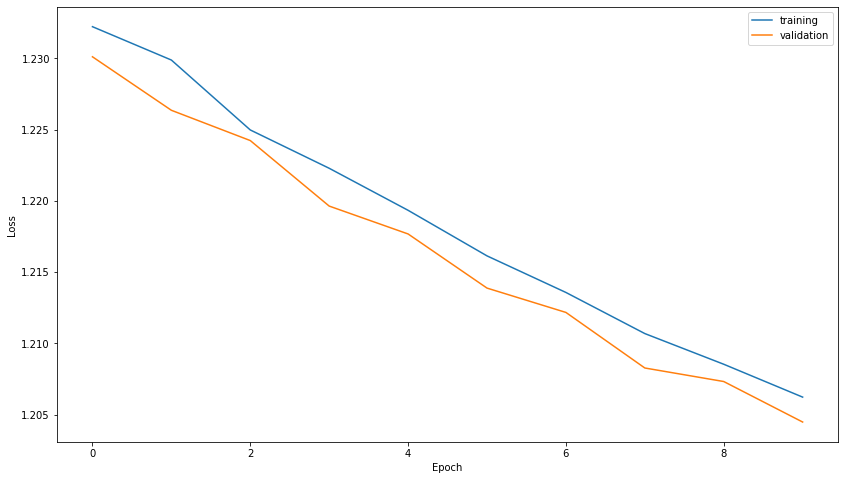

In [ ]:
fig_loss = plt.figure(figsize=(14,8))
plt.plot(np.arange(nepochs),train_loss_array,label="training")
plt.plot(np.arange(nepochs),val_loss_array,label="validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

Another common measure for the performance of a classification algorithm is a so-called ROC curve, where ROC stands for receiver operating characteristic. This sounds complicated, but is really just a plot of the true positive rate (TPR) vs the false positive rate (FPR) of our algorithm for various threshold classification scores for each class. The threshold score in this case is just the score we have to exceed for an element to be classified as a member of a given class (i.e. if our threshold score to classify a jet as a gluon jet is 0.3 and our jet has an output probability of 0.34 for this class, then it will be classified as a gluon jet). As you can imagine, a higher threshold score will lead to a purer sample of each class (lower FPR) while a lower threshold score leads to more of the elements that belong to a class to be identified as such (higher TPR). A summary of these quantities is given below: \\

---

**True Positive**: Element is part of chosen class and correctly identified as such \\
**True Negative**: Element is not part of chosen class and correctly identified as such \\
**False Positive**: Element is identified as part of chosen class, even though it is not \\
**False Negative**: Element is not identified as part of chosen class, even though it is \\

---

**TPR** = TP/(TP+FN) \\
**FPR** = FP/(FP+TN)

In [ ]:
threshold_array = np.arange(0.01,0.99,0.01)
auc_array = np.zeros((len(labels),2,len(threshold_array))) #store TPR and FPR for various threshold values for each class

for i, label in enumerate(labels):
    true_values = y_test[:,i] > 0
    for j, threshold in enumerate(threshold_array):
        threshold_pred = pred[:,i] > threshold
        tp = np.logical_and(true_values, threshold_pred).sum()
        tn = np.logical_and(~true_values, ~threshold_pred).sum()
        fp = np.logical_and(true_values, ~threshold_pred).sum()
        fn = np.logical_and(~true_values, threshold_pred).sum()
        auc_array[i,0,j] = tp/(tp+fn)
        auc_array[i,1,j] = fp/(fp+tn)

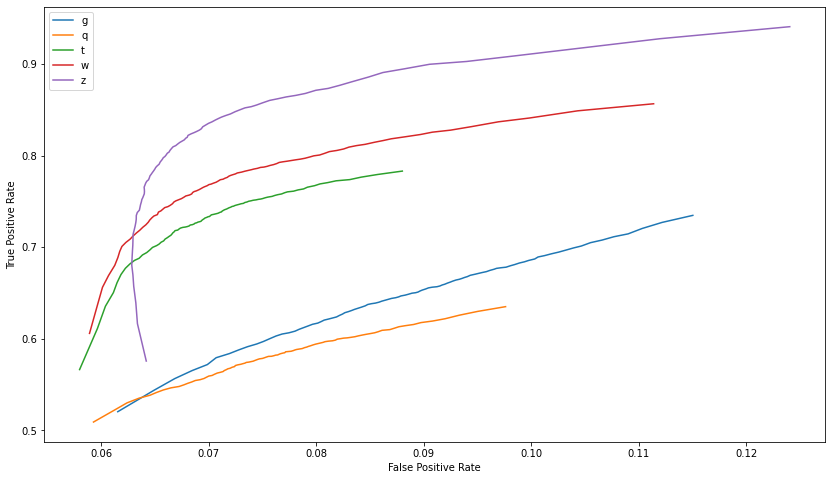

In [ ]:
fig_roc = plt.figure(figsize=(14,8))
for i, label in enumerate(labels):
    plt.plot(auc_array[i,1],auc_array[i,0],label=label)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

# Task 3: Optimize your neural network

Now that everything is set up, you can play around with the neural network architecture!

$\textbf{Question 4}$: What happens if you increase/decrease the number or size of layers in the network? How would you get the network to overtrain? First think about these questions intuitively and then run some experiments using the model. Also check if you can achieve better results than the test run!

$\textbf{Question 5}$: What happens if you remove some of the input features? Does it affect the performance of the neural network and if so, by how much? Hint: You can use numpy slicing on X before it is split into training, test and validation sets to do this.